In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import copy
from datetime import datetime, timedelta
from keras.utils import to_categorical
# import visualkeras
# import tensorflow as tf
from sklearn.metrics import balanced_accuracy_score
import optuna
from optuna.samplers import TPESampler
import keras
from keras.callbacks import ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
import sys
import os
import joblib
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import glob 

sys.path.append("/glade/u/home/jhayron/WR_Predictability/3_MLModels/")
from model_builders_v2 import *

2023-10-15 16:52:50.399509: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
/glade/work/jhayron/conda-envs/cnn_wr/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.path as mpath
import cartopy
import cartopy.crs as ccrs
import cartopy.feature
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import cartopy.feature as cf
import shapely.geometry as sgeom

In [3]:
wr_series = pd.read_csv('/glade/work/jhayron/Data4Predictability/WR_Series_20230824.csv',\
                index_col=0,names=['week0'],skiprows=1,parse_dates=True)
for wk in range(2,10):
    series_temp = copy.deepcopy(wr_series["week0"])
    series_temp.index = series_temp.index - timedelta(weeks = wk-1)
    series_temp.name = f'week{wk-1}'
    if wk==2:
        df_shifts = pd.concat([pd.DataFrame(wr_series["week0"]),pd.DataFrame(series_temp)],axis=1)  
    else:
        df_shifts = pd.concat([df_shifts,pd.DataFrame(series_temp)],axis=1)

In [4]:
path_weekly_anoms = '/glade/scratch/jhayron/Data4Predictability/WeeklyAnoms_DetrendedStd/'

In [5]:
files_weekly_anoms = np.sort(glob.glob(f'{path_weekly_anoms}/*.nc'))

In [6]:
ifile = 4

In [10]:
file_temp = files_weekly_anoms[ifile]
dataset = xr.open_dataset(file_temp)
var_name = list(dataset.data_vars.keys())[0]
print(file_temp,var_name)
dataset = dataset.load()

name_var = file_temp.split('/')[-1][:-3]

### Find and drop useless (always zero, pixels)
flattened_da = dataset.stack(flat=('lat','lon')).transpose('time','flat')[var_name]
nan_mask = flattened_da.isnull().all(dim='time')
# nan_mask = flattened_da.isnull().any(dim='time')
where_nonan = np.where(nan_mask==False)[0]
flattened_nonan = flattened_da[:,where_nonan]
flattened_nonan = flattened_nonan.fillna(0)

# create pca object
pca_obj = PCA(6, whiten=True)

# fit pca with era5
pca_obj = pca_obj.fit(flattened_nonan)

# transform era5 data with pca
transformed_da = pca_obj.transform(flattened_nonan)

print(f'Variance explained: {pca_obj.explained_variance_ratio_ * 100}')
print(f'Cumulative sum of variance explained for EOF1 and EOF2: {np.cumsum(pca_obj.explained_variance_ratio_) * 100}')
transformed_da = pd.DataFrame(transformed_da,index = dataset.time)

In [13]:
# For each PC, plot map and plot anomalies in WR histogram for each week

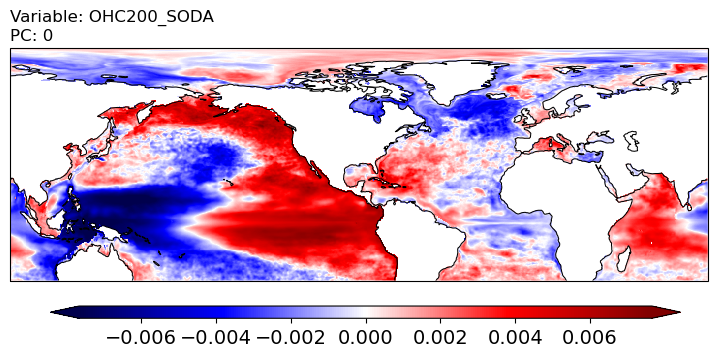

In [14]:
ipc = 0

pc_flattened_nonan = copy.deepcopy(flattened_nonan.isel(time=0))#.values
# flattened_nonan.isel(time=0).values = pca_obj.components_[0]
pc_flattened_nonan.values = pca_obj.components_[ipc]
pc_flattened = copy.deepcopy(flattened_da.isel(time=0))
array_temp = copy.deepcopy(pc_flattened.values)
array_temp[where_nonan] = pc_flattened_nonan.values
pc_flattened.values  = array_temp
unstacked_pc = pc_flattened.unstack('flat')

##########PLOT MAP #####################
symmetric_max = np.nanmax([abs(np.nanpercentile(unstacked_pc.values,0.5)),abs(np.nanpercentile(unstacked_pc.values,99.5))])
fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111,projection=ccrs.PlateCarree(central_longitude=-90+360))

# print(vmax,vmin)
cs = plt.pcolormesh(unstacked_pc.lon,unstacked_pc.lat,\
    unstacked_pc.values,cmap='seismic',
    transform=ccrs.PlateCarree(),vmin=-symmetric_max,vmax=symmetric_max)
ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
ax.margins(x=0, y=0)

plt.xlim()

plt.title(f'Variable: {name_var}\nPC: {ipc}',loc='left')

cbar_ax = fig.add_axes([0.17, 0.275, 0.7, 0.0175])
cbar = fig.colorbar(cs,cax=cbar_ax,orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=14)
# cbar.set_label(trend.units, fontsize=14)

plt.show()

In [15]:
df_wr_temp = df_shifts['week0'].dropna()
mean_hist_wrs = np.histogram(df_wr_temp,bins=np.arange(-0.5,5,1))[0]
mean_hist_wrs = mean_hist_wrs/np.sum(mean_hist_wrs)

In [21]:
normalized_pc = transformed_da[ipc]/np.nanmax(abs(transformed_da[ipc]))

In [22]:
bins = np.percentile(normalized_pc,[0,20,40,60,80,100])
mid_bins = [10,30,50,70,90]

In [23]:
week = 1
df_pc_wr = pd.concat([normalized_pc,df_shifts[f'week{week}']],axis=1).dropna()

In [25]:
prob2d = np.zeros([5,len(mid_bins)])
hist_pc_ranges = []
for ibin in range(len(bins)-1):
    # print(bin_center)
    df_temp = df_pc_wr[(df_pc_wr[ipc]>=bins[ibin])&(df_pc_wr[ipc]<=bins[ibin+1])][f'week{week}']
    # print(len(df_temp))
    hist_pc_ranges.append(len(df_temp))
    hist_temp = np.histogram(df_temp,bins=np.arange(-0.5,5,1))[0]
    hist_temp = hist_temp/np.sum(hist_temp)
    diff_temp = mean_hist_wrs-hist_temp
    prob2d[:,ibin] = diff_temp

In [27]:
names_wr = ['WR1: IH','WR2: PH', 'WR3: IL', 'WR4: PL', 'WR5: Clima']

In [28]:
avg_hist_change_for_week = np.mean(abs(prob2d),axis=0)

/glade/scratch/jhayron/ipykernel_51765/217342053.py:11: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = plt.colorbar(cm,pad=0.17)


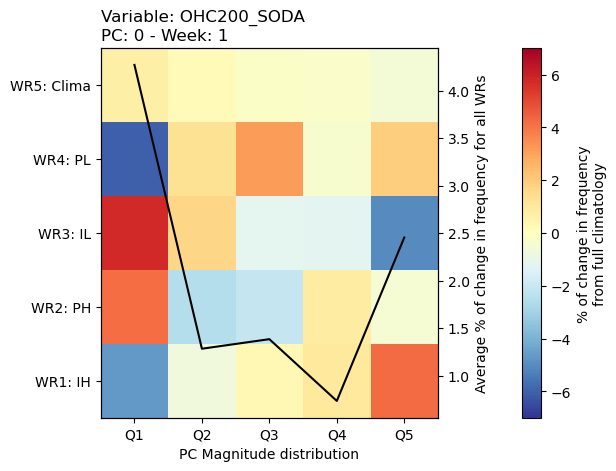

In [35]:
fig, ax1 = plt.subplots()
cm = ax1.pcolormesh(mid_bins,names_wr,prob2d*100,vmin=-7,vmax=7,cmap='RdYlBu_r')

ax1.set_xticks(mid_bins,['Q1','Q2','Q3','Q4','Q5'])
ax1.set_xlabel('PC Magnitude distribution')

ax2 = ax1.twinx()
ax2.plot(mid_bins,avg_hist_change_for_week*100,color='k')
ax2.set_ylabel('Average % of change in frequency for all WRs')

cbar = plt.colorbar(cm,pad=0.17)
cbar.set_label('% of change in frequency\nfrom full climatology')

plt.title(f'Variable: {name_var}\nPC: {ipc} - Week: {week}',loc='left')
plt.show()

#### Plot for each week ####

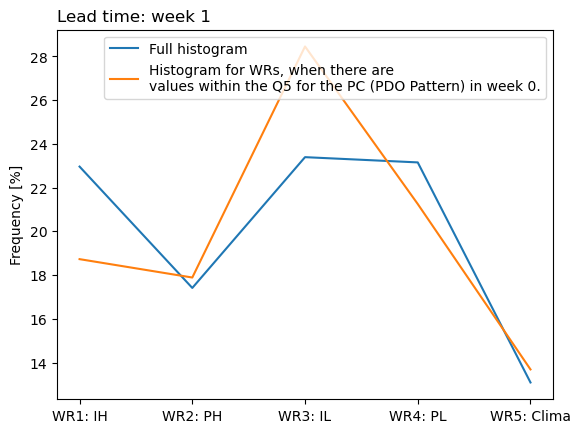

In [38]:
plt.close('all')
plt.plot(names_wr,mean_hist_wrs*100,label = 'Full histogram')
plt.plot(names_wr,hist_temp*100,label = 'Histogram for WRs, when there are \nvalues within the Q5 for the PC (PDO Pattern) in week 0.')
plt.ylabel('Frequency [%]')
plt.legend()
plt.title(f'Lead time: week {week}',loc='left')
# plt.xticks()
plt.show()

# Iterate through weeks

In [39]:
names_wr = ['WR1: IH','WR2: PH', 'WR3: IL', 'WR4: PL', 'WR5: Clima']

In [40]:
path_figures = f'/glade/u/home/jhayron/WR_Predictability/4_PCA_Analysis/figures/{name_var}/pc{ipc}/'

In [41]:
try: os.mkdir(path_figures)
except: pass

try: os.mkdir(f'/glade/u/home/jhayron/WR_Predictability/4_PCA_Analysis/figures/{name_var}/')
except: pass

In [42]:
avg_change_bins_weeks = np.zeros([len(mid_bins),len([1,2,3,4,5,6,7,8])])

for week in [1,2,3,4,5,6,7,8]:
    df_pc_wr = pd.concat([normalized_pc,df_shifts[f'week{week}']],axis=1).dropna()

    prob2d = np.zeros([5,len(mid_bins)])
    for ibin in range(len(bins)-1):
        # print(bin_center)
        df_temp = df_pc_wr[(df_pc_wr[ipc]>=bins[ibin])&(df_pc_wr[ipc]<=bins[ibin+1])][f'week{week}']
        hist_temp = np.histogram(df_temp,bins=np.arange(-0.5,5,1))[0]
        hist_temp = hist_temp/np.sum(hist_temp)
        diff_temp = mean_hist_wrs-hist_temp
        prob2d[:,ibin] = diff_temp
    avg_hist_change_for_week = np.mean(abs(prob2d),axis=0)
    avg_change_bins_weeks[:,week-1] = avg_hist_change_for_week
    
    ### Plot for week ###
    fig, ax1 = plt.subplots()
    cm = ax1.pcolormesh(mid_bins,names_wr,prob2d*100,vmin=-7,vmax=7,cmap='RdYlBu_r')

    ax1.set_xticks(mid_bins,['Q1','Q2','Q3','Q4','Q5'])
    ax1.set_xlabel('PC Magnitude distribution')

    ax2 = ax1.twinx()
    ax2.plot(mid_bins,avg_hist_change_for_week*100,color='k')
    ax2.set_ylabel('Average % of change in frequency for all WRs')

    cbar = plt.colorbar(cm,pad=0.17)
    cbar.set_label('% of change in frequency\nfrom full climatology')

    plt.title(f'Variable: {name_var}\nPC: {ipc} - Week: {week}',loc='left')
    plt.savefig(f'{path_figures}2dDiff_{name_var}_PC{ipc}_week{week}.png')
    plt.close('all')
    
fig, ax1 = plt.subplots()
cm = ax1.pcolormesh([1,2,3,4,5,6,7,8],mid_bins,avg_change_bins_weeks*100,
                    vmin=0,cmap='YlOrRd')

ax1.set_yticks(mid_bins)
ax1.set_xlabel('Lead time week')
ax1.set_ylabel('Normalized PC Magnitude')

# ax2 = ax1.twinx()
# ax2.plot(mid_bins,avg_hist_change_for_week*100,color='k')
# ax2.set_ylabel('Average % of change in frequency for all WRs')

cbar = plt.colorbar(cm)
cbar.set_label('Average % absolute change in frequency')

plt.title(f'Variable: {name_var}\nPC: {ipc}',loc='left')
plt.savefig(f'/glade/u/home/jhayron/WR_Predictability/4_PCA_Analysis/figures/{name_var}/abs_chng_freq_pc{ipc}.png',
            bbox_inches='tight')
plt.close('all')

/glade/scratch/jhayron/ipykernel_51765/9429750.py:28: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = plt.colorbar(cm,pad=0.17)
/glade/scratch/jhayron/ipykernel_51765/9429750.py:28: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = plt.colorbar(cm,pad=0.17)
/glade/scratch/jhayron/ipykernel_51765/9429750.py:28: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = plt.colorbar(cm,pa

# Iterate through PCs

In [368]:
df_wr_temp = df_shifts['week0'].dropna()
mean_hist_wrs = np.histogram(df_wr_temp,bins=np.arange(-0.5,5,1))[0]
mean_hist_wrs = mean_hist_wrs/np.sum(mean_hist_wrs)

In [43]:
try: os.mkdir(f'/glade/u/home/jhayron/WR_Predictability/4_PCA_Analysis/figures/{name_var}/')
except: pass

transformed_da.to_csv(f'/glade/u/home/jhayron/WR_Predictability/4_PCA_Analysis/figures/{name_var}/PC_{name_var}.csv')

for ipc in range(6):
    ##########Unstack PC #####################
    pc_flattened_nonan = copy.deepcopy(flattened_nonan.isel(time=0))#.values
    # flattened_nonan.isel(time=0).values = pca_obj.components_[0]
    pc_flattened_nonan.values = pca_obj.components_[ipc]
    pc_flattened = copy.deepcopy(flattened_da.isel(time=0))
    array_temp = copy.deepcopy(pc_flattened.values)
    array_temp[where_nonan] = pc_flattened_nonan.values
    pc_flattened.values  = array_temp
    unstacked_pc = pc_flattened.unstack('flat')

    ##########PLOT MAP #####################
    symmetric_max = np.nanmax([abs(np.nanpercentile(unstacked_pc.values,0.5)),abs(np.nanpercentile(unstacked_pc.values,99.5))])
    fig = plt.figure(figsize=(9,7))
    ax = fig.add_subplot(111,projection=ccrs.PlateCarree(central_longitude=-90+360))

    # print(vmax,vmin)
    cs = plt.pcolormesh(unstacked_pc.lon,unstacked_pc.lat,\
        unstacked_pc.values,cmap='seismic',
        transform=ccrs.PlateCarree(),vmin=-symmetric_max,vmax=symmetric_max)
    ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
    ax.margins(x=0, y=0)

    plt.xlim()

    plt.title(f'Variable: {name_var}\nPC: {ipc}',loc='left')

    cbar_ax = fig.add_axes([0.17, 0.275, 0.7, 0.0175])
    cbar = fig.colorbar(cs,cax=cbar_ax,orientation='horizontal', extend='both')
    cbar.ax.tick_params(labelsize=14)
    # cbar.set_label(trend.units, fontsize=14)

    plt.savefig(f'/glade/u/home/jhayron/WR_Predictability/4_PCA_Analysis/figures/{name_var}/map_pc{ipc}.png',
            bbox_inches='tight')
    plt.close('all')
    ##########Normalize PC #####################
    normalized_pc = transformed_da[ipc]/np.nanmax(abs(transformed_da[ipc]))
    # plt.plot(normalized_pc)
    # plt.show()
    # plt.close('all')
    ##########Get conditional histogram for each bin within PC #####################
    bins = np.percentile(normalized_pc,[0,20,40,60,80,100])
    mid_bins = [10,30,50,70,90]
    
    avg_change_bins_weeks = np.zeros([len(mid_bins),len([1,2,3,4,5,6,7,8])])
    
    path_figures = f'/glade/u/home/jhayron/WR_Predictability/4_PCA_Analysis/figures/{name_var}/pc{ipc}/'
    try: os.mkdir(path_figures)
    except: pass

    for week in [1,2,3,4,5,6,7,8]:
        df_pc_wr = pd.concat([normalized_pc,df_shifts[f'week{week}']],axis=1).dropna()

        for ibin in range(len(bins)-1):
            # print(bin_center)
            df_temp = df_pc_wr[(df_pc_wr[ipc]>=bins[ibin])&(df_pc_wr[ipc]<=bins[ibin+1])][f'week{week}']
            hist_temp = np.histogram(df_temp,bins=np.arange(-0.5,5,1))[0]
            hist_temp = hist_temp/np.sum(hist_temp)
            diff_temp = mean_hist_wrs-hist_temp
            prob2d[:,ibin] = diff_temp
        avg_hist_change_for_week = np.mean(abs(prob2d),axis=0)
        avg_change_bins_weeks[:,week-1] = avg_hist_change_for_week

        ### Plot for week ###
        fig, ax1 = plt.subplots()
        cm = ax1.pcolormesh(mid_bins,names_wr,prob2d*100,vmin=-12,vmax=12,cmap='RdYlBu_r')

        ax1.set_xticks(mid_bins,['Q1','Q2','Q3','Q4','Q5'])
        ax1.set_xlabel('PC Magnitude distribution')

        ax2 = ax1.twinx()
        ax2.plot(mid_bins,avg_hist_change_for_week*100,color='k')
        ax2.set_ylabel('Average % of change in frequency for all WRs')

        cbar = plt.colorbar(cm,pad=0.17)
        cbar.set_label('% of change in frequency\nfrom full climatology')

        plt.title(f'Variable: {name_var}\nPC: {ipc} - Week: {week}',loc='left')
        plt.savefig(f'{path_figures}2dDiff_{name_var}_PC{ipc}_week{week}.png')
        plt.close('all')
    
    ##########Plot average change in frequency for each week and bin #####################
    fig, ax1 = plt.subplots()
    cm = ax1.pcolormesh([1,2,3,4,5,6,7,8],mid_bins,avg_change_bins_weeks*100,
                        vmin=0,cmap='YlOrRd')

    ax1.set_yticks(mid_bins)
    ax1.set_xlabel('Lead time week')
    ax1.set_ylabel('Normalized PC Magnitude')

    # ax2 = ax1.twinx()
    # ax2.plot(mid_bins,avg_hist_change_for_week*100,color='k')
    # ax2.set_ylabel('Average % of change in frequency for all WRs')

    cbar = plt.colorbar(cm)
    cbar.set_label('Average % absolute change in frequency')

    plt.title(f'Variable: {name_var}\nPC: {ipc}',loc='left')
    plt.savefig(f'/glade/u/home/jhayron/WR_Predictability/4_PCA_Analysis/figures/{name_var}/abs_chng_freq_pc{ipc}.png',
                bbox_inches='tight')
    plt.close('all')

/glade/scratch/jhayron/ipykernel_51765/4129905589.py:80: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = plt.colorbar(cm,pad=0.17)
/glade/scratch/jhayron/ipykernel_51765/4129905589.py:80: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = plt.colorbar(cm,pad=0.17)
/glade/scratch/jhayron/ipykernel_51765/4129905589.py:80: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = plt.color

# Iterate through all variables

In [69]:
for ifile in range(3,len(files_weekly_anoms)):
    file_temp = files_weekly_anoms[ifile]
    dataset = xr.open_dataset(file_temp)
    var_name = list(dataset.data_vars.keys())[0]
    print(file_temp,var_name)
    dataset = dataset.load()

    name_var = file_temp.split('/')[-1][:-3]

    ### Find and drop useless (always zero, pixels)
    flattened_da = dataset.stack(flat=('lat','lon')).transpose('time','flat')[var_name]
    # nan_mask = flattened_da.isnull().all(dim='time')
    nan_mask = flattened_da.isnull().any(dim='time')
    where_nonan = np.where(nan_mask==False)[0]
    flattened_nonan = flattened_da[:,where_nonan]
    flattened_nonan = flattened_nonan.fillna(0)
    # aaaa
    # create pca object
    pca_obj = PCA(6, whiten=True)

    # fit pca with era5
    pca_obj = pca_obj.fit(flattened_nonan)

    # transform era5 data with pca
    transformed_da = pca_obj.transform(flattened_nonan)

    print(f'Variance explained: {pca_obj.explained_variance_ratio_ * 100}')
    print(f'Cumulative sum of variance explained for EOF1 and EOF2: {np.cumsum(pca_obj.explained_variance_ratio_) * 100}')
    transformed_da = pd.DataFrame(transformed_da,index = dataset.time)


    df_wr_temp = df_shifts['week0'].dropna()
    mean_hist_wrs = np.histogram(df_wr_temp,bins=np.arange(-0.5,5,1))[0]
    mean_hist_wrs = mean_hist_wrs/np.sum(mean_hist_wrs)

    try: os.mkdir(f'/glade/u/home/jhayron/WR_Predictability/4_PCA_Analysis/figures/{name_var}/')
    except: pass

    transformed_da.to_csv(f'/glade/u/home/jhayron/WR_Predictability/4_PCA_Analysis/figures/{name_var}/PC_{name_var}.csv')

    for ipc in range(6):
        ##########Unstack PC #####################
        pc_flattened_nonan = copy.deepcopy(flattened_nonan.isel(time=0))#.values
        # flattened_nonan.isel(time=0).values = pca_obj.components_[0]
        pc_flattened_nonan.values = pca_obj.components_[ipc]
        pc_flattened = copy.deepcopy(flattened_da.isel(time=0))
        array_temp = copy.deepcopy(pc_flattened.values)
        array_temp[where_nonan] = pc_flattened_nonan.values
        pc_flattened.values  = array_temp
        unstacked_pc = pc_flattened.unstack('flat')

        ##########PLOT MAP #####################
        symmetric_max = np.nanmax([abs(np.nanpercentile(unstacked_pc.values,0.5)),abs(np.nanpercentile(unstacked_pc.values,99.5))])
        fig = plt.figure(figsize=(9,7))
        ax = fig.add_subplot(111,projection=ccrs.PlateCarree(central_longitude=-90+360))

        # print(vmax,vmin)
        cs = plt.pcolormesh(unstacked_pc.lon,unstacked_pc.lat,\
            unstacked_pc.values,cmap='seismic',
            transform=ccrs.PlateCarree(),vmin=-symmetric_max,vmax=symmetric_max)
        ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
        ax.margins(x=0, y=0)

        plt.xlim()

        plt.title(f'Variable: {name_var}\nPC: {ipc}',loc='left')

        cbar_ax = fig.add_axes([0.17, 0.275, 0.7, 0.0175])
        cbar = fig.colorbar(cs,cax=cbar_ax,orientation='horizontal', extend='both')
        cbar.ax.tick_params(labelsize=14)
        # cbar.set_label(trend.units, fontsize=14)

        plt.savefig(f'/glade/u/home/jhayron/WR_Predictability/4_PCA_Analysis/figures/{name_var}/map_pc{ipc}.png',
                bbox_inches='tight')
        plt.close('all')
        ##########Normalize PC #####################
        normalized_pc = transformed_da[ipc]/np.nanmax(abs(transformed_da[ipc]))
        # plt.plot(normalized_pc)
        # plt.show()
        # plt.close('all')
        ##########Get conditional histogram for each bin within PC #####################
        bins = np.percentile(normalized_pc,[0,20,40,60,80,100])
        mid_bins = [10,30,50,70,90]

        avg_change_bins_weeks = np.zeros([len(mid_bins),len([1,2,3,4,5,6,7,8])])

        path_figures = f'/glade/u/home/jhayron/WR_Predictability/4_PCA_Analysis/figures/{name_var}/pc{ipc}/'
        try: os.mkdir(path_figures)
        except: pass

        for week in [1,2,3,4,5,6,7,8]:
            df_pc_wr = pd.concat([normalized_pc,df_shifts[f'week{week}']],axis=1).dropna()

            for ibin in range(len(bins)-1):
                # print(bin_center)
                df_temp = df_pc_wr[(df_pc_wr[ipc]>=bins[ibin])&(df_pc_wr[ipc]<=bins[ibin+1])][f'week{week}']
                hist_temp = np.histogram(df_temp,bins=np.arange(-0.5,5,1))[0]
                hist_temp = hist_temp/np.sum(hist_temp)
                diff_temp = mean_hist_wrs-hist_temp
                prob2d[:,ibin] = diff_temp
            avg_hist_change_for_week = np.mean(abs(prob2d),axis=0)
            avg_change_bins_weeks[:,week-1] = avg_hist_change_for_week

            ### Plot for week ###
            fig, ax1 = plt.subplots()
            cm = ax1.pcolormesh(mid_bins,names_wr,prob2d*100,vmin=-12,vmax=12,cmap='RdYlBu_r')

            ax1.set_xticks(mid_bins,['Q1','Q2','Q3','Q4','Q5'])
            ax1.set_xlabel('PC Magnitude distribution')

            ax2 = ax1.twinx()
            ax2.plot(mid_bins,avg_hist_change_for_week*100,color='k')
            ax2.set_ylabel('Average % of change in frequency for all WRs')

            cbar = plt.colorbar(cm,pad=0.17,ax=ax1)
            cbar.set_label('% of change in frequency\nfrom full climatology')

            plt.title(f'Variable: {name_var}\nPC: {ipc} - Week: {week}',loc='left')
            plt.savefig(f'{path_figures}2dDiff_{name_var}_PC{ipc}_week{week}.png')
            plt.close('all')

        ##########Plot average change in frequency for each week and bin #####################
        fig, ax1 = plt.subplots()
        cm = ax1.pcolormesh([1,2,3,4,5,6,7,8],mid_bins,avg_change_bins_weeks*100,
                            vmin=0,cmap='YlOrRd')

        ax1.set_yticks(mid_bins)
        ax1.set_xlabel('Lead time week')
        ax1.set_ylabel('Normalized PC Magnitude')

        # ax2 = ax1.twinx()
        # ax2.plot(mid_bins,avg_hist_change_for_week*100,color='k')
        # ax2.set_ylabel('Average % of change in frequency for all WRs')

        cbar = plt.colorbar(cm,ax=ax1)
        cbar.set_label('Average % absolute change in frequency')

        plt.title(f'Variable: {name_var}\nPC: {ipc}',loc='left')
        plt.savefig(f'/glade/u/home/jhayron/WR_Predictability/4_PCA_Analysis/figures/{name_var}/abs_chng_freq_pc{ipc}.png',
                    bbox_inches='tight')
        plt.close('all')
    # aaaa

/glade/scratch/jhayron/Data4Predictability/WeeklyAnoms_DetrendedStd/IC_SODA.nc cn_total_anomalies
Variance explained: [9.73377161e+01 1.44180061e+00 1.12611503e+00 5.87420354e-02
 2.62582220e-02 9.35634040e-03]
Cumulative sum of variance explained for EOF1 and EOF2: [97.33771611 98.77951672 99.90563175 99.96437379 99.99063201 99.99998835]
/glade/scratch/jhayron/Data4Predictability/WeeklyAnoms_DetrendedStd/IT_SODA.nc hi_anomalies
Variance explained: [9.77009800e+01 2.11670521e+00 1.81882375e-01 3.88178578e-04
 1.35527768e-05 1.08530981e-05]
Cumulative sum of variance explained for EOF1 and EOF2: [97.70098    99.81768521 99.99956758 99.99995576 99.99996932 99.99998017]
/glade/scratch/jhayron/Data4Predictability/WeeklyAnoms_DetrendedStd/MLD_SODA.nc mlt_anomalies
Variance explained: [75.15245847  8.30680996  5.32317601  2.68862656  2.11267314  1.39467334]
Cumulative sum of variance explained for EOF1 and EOF2: [75.15245847 83.45926843 88.78244444 91.471071   93.58374414 94.97841748]
/glade

/glade/scratch/jhayron/ipykernel_51765/389706928.py:98: RuntimeWarning: invalid value encountered in true_divide
  hist_temp = hist_temp/np.sum(hist_temp)
/glade/scratch/jhayron/ipykernel_51765/389706928.py:98: RuntimeWarning: invalid value encountered in true_divide
  hist_temp = hist_temp/np.sum(hist_temp)
/glade/scratch/jhayron/ipykernel_51765/389706928.py:98: RuntimeWarning: invalid value encountered in true_divide
  hist_temp = hist_temp/np.sum(hist_temp)
/glade/scratch/jhayron/ipykernel_51765/389706928.py:98: RuntimeWarning: invalid value encountered in true_divide
  hist_temp = hist_temp/np.sum(hist_temp)
/glade/scratch/jhayron/ipykernel_51765/389706928.py:98: RuntimeWarning: invalid value encountered in true_divide
  hist_temp = hist_temp/np.sum(hist_temp)
/glade/scratch/jhayron/ipykernel_51765/389706928.py:98: RuntimeWarning: invalid value encountered in true_divide
  hist_temp = hist_temp/np.sum(hist_temp)
/glade/scratch/jhayron/ipykernel_51765/389706928.py:98: RuntimeWarning

/glade/scratch/jhayron/Data4Predictability/WeeklyAnoms_DetrendedStd/SST_SODA.nc temp_anomalies
Variance explained: [52.25173024  4.32406089  3.61385576  3.43745007  2.00027878  1.68997203]
Cumulative sum of variance explained for EOF1 and EOF2: [52.25173024 56.57579113 60.18964688 63.62709695 65.62737573 67.31734776]
/glade/scratch/jhayron/Data4Predictability/WeeklyAnoms_DetrendedStd/STL_1m_ERA5.nc STL_1m_anomalies
Variance explained: [77.51848429 11.45841238  4.64147802  2.69446957  0.92377197  0.65670815]
Cumulative sum of variance explained for EOF1 and EOF2: [77.51848429 88.97689666 93.61837468 96.31284426 97.23661623 97.89332438]
/glade/scratch/jhayron/Data4Predictability/WeeklyAnoms_DetrendedStd/STL_28cm_ERA5.nc STL_28cm_anomalies
Variance explained: [78.03777044 11.04746071  4.70732581  2.5399911   0.95854676  0.63100738]
Cumulative sum of variance explained for EOF1 and EOF2: [78.03777044 89.08523115 93.79255696 96.33254806 97.29109482 97.9221022 ]
/glade/scratch/jhayron/Data4P